Import libraries

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
from tensorflow.keras.preprocessing import image

Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2,os

data_path = '/content/drive/My Drive/dataset/dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [ ]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [ ]:
img_path

'/content/drive/My Drive/dataset/dataset/without mask/augmented_image_139.jpg'

In [ ]:
img_path


'/content/drive/My Drive/dataset/dataset/without mask/augmented_image_139.jpg'

In [ ]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [ ]:
np.save('data',data)
np.save('target',new_target)

In [ ]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=5,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/5
31/31 [==============================] - 89s 3s/step - loss: 0.6956 - accuracy: 0.5545 - val_loss: 0.5805 - val_accuracy: 0.7097
Epoch 2/5
31/31 [==============================] - 85s 3s/step - loss: 0.5016 - accuracy: 0.7717 - val_loss: 0.4084 - val_accuracy: 0.8387
Epoch 3/5
31/31 [==============================] - 85s 3s/step - loss: 0.2917 - accuracy: 0.8778 - val_loss: 0.3167 - val_accuracy: 0.8710
Epoch 4/5
31/31 [==============================] - 85s 3s/step - loss: 0.2190 - accuracy: 0.9202 - val_loss: 0.2468 - val_accuracy: 0.9113
Epoch 5/5
31/31 [==============================] - 85s 3s/step - loss: 0.1420 - accuracy: 0.9495 - val_loss: 0.1851 - val_accuracy: 0.9355


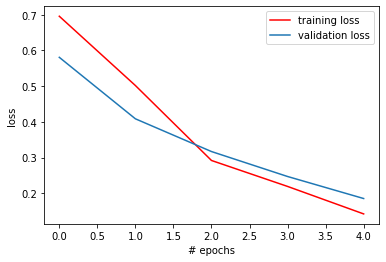

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

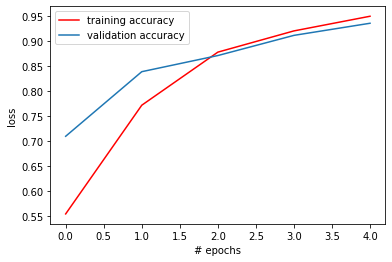

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 3s 568ms/step - loss: 0.1376 - accuracy: 0.9638
[0.1376330852508545, 0.9637681245803833]


In [ ]:
from keras.models import load_model
import cv2
import numpy as np

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
 print(img)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [ ]:
model = load_model('model-007.model')
xml_path = '/content/drive/My Drive/dataset/haarcascade_frontalface_default.xml'
face_clsfr=cv2.CascadeClassifier(xml_path)

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
source


<VideoCapture 0x7f4e21ee0870>

In [ ]:
while(True):

    ret, img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)

    for x,y,w,h in faces:

        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)


    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)

    if(key==27):
        break

cv2.destroyAllWindows()
source.release()

error: ignored

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
#try:
    #img: np.array = cv2.imread('photo.jpg', cv2.IMREAD_COLOR)
    #gray: np.array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ##gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #faces=face_clsfr.detectMultiScale(gray,1.3,5)
#except:
    #exeption as e
    #print("exception", e)



In [ ]:
mymodel=load_model('mymodel.h5')

cap=cv2.VideoCapture(0)
face_cascade=cv2.CascadeClassifier('xml_path')

while cap.isOpened():
    _,img=cap.read()
    face=face_cascade.detectMultiScale(img,scaleFactor=1.1,minNeighbors=4)
    for(x,y,w,h) in face:
        face_img = img[y:y+h, x:x+w]
        cv2.imwrite('temp.jpg',face_img)
        test_image=image.load_img('temp.jpg',target_size=(150,150,3))
        test_image=image.img_to_array(test_image)
        test_image=np.expand_dims(test_image,axis=0)
        pred=mymodel.predict(test_image)[0][0]
        if pred==1:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)
            cv2.putText(img,'NO MASK',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),3)
        else:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
            cv2.putText(img,'MASK',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),3)
        datet=str(datetime.datetime.now())
        cv2.putText(img,datet,(400,450),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)

    cv2.imshow('img',img)

    if cv2.waitKey(1)==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
while(True):

    ret, img = source.read()
    #img = image.load_img("photo.jpg")
    #imgs = image.img_to_array(source)
    #imgs = np.expand_dims(imgs, axis = 0)
    #img = np.vstack([imgs])
    #img: np.array = cv2.imread('photo.jpg', cv2.IMREAD_COLOR)
    gray: np.array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)

    for x,y,w,h in faces:

        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)


    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)

    if(key==27):
        break

cv2.destroyAllWindows()
source.release()